In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [72]:
GPU_TDP = 250 # Watt
CPU_TDP = 85 # Watt
GPU_utilisation =  70 #percentage
CPU_utilisation = 1 #assumed

In [2]:
df_reading = pd.read_csv("logs/power_reading_glue.csv")

In [3]:
df_reading['last_changed'] = pd.to_datetime(df_reading['last_changed'], errors='coerce')
df_reading.dropna(subset=['last_changed'], inplace=True)
df_reading.set_index('last_changed', inplace=True)

In [4]:
df_time_interval = pd.read_csv("logs/inferenceTextClass13f4c3e6-cf47-4901-8512-8d8c0c0f909d.csv")

In [5]:
df_time_interval['start_seconds']= [datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                  for start_time in df_time_interval.start_time]
df_time_interval['end_seconds'] = [datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                for end_time in df_time_interval.end_time]
df_time_interval['total_time'] = df_time_interval['end_seconds'] - df_time_interval['start_seconds']
df_time_interval['total_time'] = df_time_interval['total_time'].apply(lambda x: x.total_seconds())
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time
0,MRPC,2020-06-29 23:41:36.427207,2020-06-29 23:42:31.367912,2020-06-29 22:41:36.427207,2020-06-29 22:42:31.367912,54.940705
1,STS-B,2020-06-29 23:43:50.022453,2020-06-29 23:44:45.388476,2020-06-29 22:43:50.022453,2020-06-29 22:44:45.388476,55.366023
2,CoLA,2020-06-29 23:45:01.687218,2020-06-29 23:45:48.487155,2020-06-29 22:45:01.687218,2020-06-29 22:45:48.487155,46.799937


In [6]:
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start_seconds"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end_seconds"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start_seconds"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end_seconds"]]
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time,s_date,e_date,s_time,e_time
0,MRPC,2020-06-29 23:41:36.427207,2020-06-29 23:42:31.367912,2020-06-29 22:41:36.427207,2020-06-29 22:42:31.367912,54.940705,2020-06-29,2020-06-29,22:41:36,22:42:31
1,STS-B,2020-06-29 23:43:50.022453,2020-06-29 23:44:45.388476,2020-06-29 22:43:50.022453,2020-06-29 22:44:45.388476,55.366023,2020-06-29,2020-06-29,22:43:50,22:44:45
2,CoLA,2020-06-29 23:45:01.687218,2020-06-29 23:45:48.487155,2020-06-29 22:45:01.687218,2020-06-29 22:45:48.487155,46.799937,2020-06-29,2020-06-29,22:45:01,22:45:48


In [7]:
def power_mean(s_date,e_date,s_time,e_time):
    subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return subset_df['power_consumption'].mean()

In [8]:
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600)

In [9]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'mean_power'] = power_mean(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [10]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'pm_energy_consumption'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [11]:
df_time_interval['power'] = df_time_interval['mean_power'] * df_time_interval['total_time']
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time,s_date,e_date,s_time,e_time,mean_power,pm_energy_consumption,power
0,MRPC,2020-06-29 23:41:36.427207,2020-06-29 23:42:31.367912,2020-06-29 22:41:36.427207,2020-06-29 22:42:31.367912,54.940705,2020-06-29,2020-06-29,22:41:36,22:42:31,135.240667,0.002029,7430.217571
1,STS-B,2020-06-29 23:43:50.022453,2020-06-29 23:44:45.388476,2020-06-29 22:43:50.022453,2020-06-29 22:44:45.388476,55.366023,2020-06-29,2020-06-29,22:43:50,22:44:45,134.521000,0.002130,7447.892780
2,CoLA,2020-06-29 23:45:01.687218,2020-06-29 23:45:48.487155,2020-06-29 22:45:01.687218,2020-06-29 22:45:48.487155,46.799937,2020-06-29,2020-06-29,22:45:01,22:45:48,131.045187,0.001747,6132.906519


In [12]:
df_co2 = pd.read_csv("results/co2data.csv")
uk_co2 = df_co2.loc[df_co2.country == 'United Kingdom'].impact.mean()

df_time_interval['CO2e'] = uk_co2 * df_time_interval['pm_energy_consumption']
df_time_interval['kg CO2e/kWh'] = df_time_interval['CO2e'] /1000

In [73]:
df_time_interval['time * GPU TDP'] = df_time_interval['total_time']/3600 * GPU_TDP  / 1000
df_time_interval['time * (GPU + CPU)'] =((df_time_interval['total_time']/3600 * GPU_TDP) +
                                         (df_time_interval['total_time']/3600 * CPU_TDP)) / 1000
df_time_interval['time * (GPU + CPU) * real_util'] = ((df_time_interval['total_time']/3600 * 
                                                       GPU_TDP * GPU_utilisation/100 )
                                                  + (df_time_interval['total_time']/3600 * 
                                                     CPU_TDP * CPU_utilisation)) / 1000

df_time_interval['time * CPU'] = df_time_interval['total_time']/3600 * CPU_TDP / 1000

In [74]:
features = ['model','time * GPU TDP','time * (GPU + CPU)',
            'time * (GPU + CPU) * real_util','time * CPU','pm_energy_consumption','kg CO2e/kWh']
df_time_interval[features]

,model,time * GPU TDP,time * (GPU + CPU),time * (GPU + CPU) * real_util,time * CPU,pm_energy_consumption,kg CO2e/kWh
0,MRPC,0.003815,0.005113,0.003968,0.001297,0.002029,0.001264
1,STS-B,0.003845,0.005152,0.003999,0.001307,0.002130,0.001327
2,CoLA,0.003250,0.004355,0.003380,0.001105,0.001747,0.001089


In [14]:
df_time_interval['daily_consumption'] = 60 * 60 * 24 * 4000 * df_time_interval['pm_energy_consumption'] / df_time_interval['total_time']
df_time_interval['monthly_consumption'] = df_time_interval['daily_consumption'] * 30
df_time_interval['yearly_consumption'] = df_time_interval['daily_consumption'] * 365
df_time_interval

,model,start_time,end_time,start_seconds,end_seconds,total_time,s_date,e_date,s_time,e_time,mean_power,pm_energy_consumption,power,CO2e,kg CO2e/kWh,daily_consumption,monthly_consumption,yearly_consumption
0,MRPC,2020-06-29 23:41:36.427207,2020-06-29 23:42:31.367912,2020-06-29 22:41:36.427207,2020-06-29 22:42:31.367912,54.940705,2020-06-29,2020-06-29,22:41:36,22:42:31,135.240667,0.002029,7430.217571,1.263824,0.001264,12760.804871,382824.146141,4.657694e+06
1,STS-B,2020-06-29 23:43:50.022453,2020-06-29 23:44:45.388476,2020-06-29 22:43:50.022453,2020-06-29 22:44:45.388476,55.366023,2020-06-29,2020-06-29,22:43:50,22:44:45,134.521000,0.002130,7447.892780,1.326938,0.001327,13295.137922,398854.137672,4.852725e+06
2,CoLA,2020-06-29 23:45:01.687218,2020-06-29 23:45:48.487155,2020-06-29 22:45:01.687218,2020-06-29 22:45:48.487155,46.799937,2020-06-29,2020-06-29,22:45:01,22:45:48,131.045187,0.001747,6132.906519,1.088549,0.001089,12902.928139,387087.844157,4.709569e+06


In [17]:
df_time_interval['daily_consumption'].mean() *  5000000 * 0.01/100

6493145.155387019

In [18]:
df_time_interval['monthly_consumption'].mean() * 5000000 * 0.01/100

194794354.66161057

In [19]:
df_time_interval['yearly_consumption'].mean() * 5000000 * 0.01/100

2369997981.716262

In [20]:
df_time_interval['daily_CO2e'] = uk_co2 * df_time_interval['daily_consumption']
df_time_interval['daily kg CO2e/kWh'] = df_time_interval['daily_CO2e'] /1000
df_time_interval['monthly_CO2e'] = uk_co2 * df_time_interval['monthly_consumption']
df_time_interval['monthly kg CO2e/kWh'] = df_time_interval['monthly_CO2e'] /1000
df_time_interval['yearly_CO2e'] = uk_co2 * df_time_interval['yearly_consumption']
df_time_interval['yearly kg CO2e/kWh'] = df_time_interval['yearly_CO2e'] /1000

In [21]:
# mean values 
# mean_df = pd.DataFrame()
# mean_df['process'] = ["Inference"]
# mean_df['daily_consumption'] = [df_time_interval['daily_consumption'].mean() *  5000000 * 0.01/100]
# mean_df['monthly_consumption'] = [df_time_interval['monthly_consumption'].mean() *  5000000 * 0.01/100]
# mean_df['yearly_consumption'] = [df_time_interval['yearly_consumption'].mean() *  5000000 * 0.01/100]
# mean_df['daily_co2'] = [df_time_interval['daily kg CO2e/kWh'].mean() *  5000000 * 0.01/100]
# mean_df['monthly_co2'] = [df_time_interval['monthly kg CO2e/kWh'].mean() *  5000000 * 0.01/100]
# mean_df['yearly_co2'] = [df_time_interval['yearly kg CO2e/kWh'].mean() *  5000000 * 0.01/100]

In [22]:
# mean_df

In [23]:
# finetune_data = pd.read_csv("logs/approx_consumption.csv")

In [24]:
# mean_df = mean_df.append(finetune_data, ignore_index=True)

In [44]:
pretrain_consumption = 1507
pretrain_daily = (1507 / 79) * 24
pretrain_monthly_co2 = uk_co2 * pretrain_consumption / 1000
pretrain_daily_co2 = uk_co2 * pretrain_daily / 1000
pretrain_array = ["Pretraining",pretrain_daily, pretrain_consumption, pretrain_consumption,pretrain_daily_co2,
                  pretrain_monthly_co2,pretrain_monthly_co2]


In [45]:
# mean_df.loc[3] = pretrain_array

In [46]:
## better way 
inference_array = ["Inference",
                   df_time_interval['daily_consumption'].mean() *  5000000 * 0.01/100,
                  df_time_interval['monthly_consumption'].mean() *  5000000 * 0.01/100,
                  df_time_interval['yearly_consumption'].mean() *  5000000 * 0.01/100,
                  df_time_interval['daily kg CO2e/kWh'].mean() *  5000000 * 0.01/100,
                   df_time_interval['monthly kg CO2e/kWh'].mean() *  5000000 * 0.01/100,
                    df_time_interval['yearly kg CO2e/kWh'].mean() *  5000000 * 0.01/100]

In [47]:
import json
with open('logs/finetune_consumption_data.txt', 'r') as filehandle:
    finetune_array = json.load(filehandle)

In [48]:
data = []

data.append(pretrain_array)
data.append(finetune_array)
data.append(inference_array)

In [49]:
mean_df = pd.DataFrame(data, columns=["process","daily_consumption",
                                 "monthly_consumption","yearly_consumption","daily_co2",
                                 "monthly_co2","yearly_co2"])

In [50]:
mean_df

,process,daily_consumption,monthly_consumption,yearly_consumption,daily_co2,monthly_co2,yearly_co2
0,Pretraining,4.578228e+02,1.507000e+03,1.507000e+03,2.852236e+02,9.388610e+02,9.388610e+02
1,Finetuning,2.180561e+04,6.541682e+05,7.850019e+06,1.358489e+04,4.075468e+05,4.890562e+06
2,Inference,6.493145e+06,1.947944e+08,2.369998e+09,4.045229e+06,1.213569e+08,1.476509e+09


In [51]:
transform_data = [
["Pretraining","Day",pretrain_array[1],pretrain_array[4]],
["Pretraining","Month",pretrain_array[2],pretrain_array[5]],
["Pretraining","Year",pretrain_array[3],pretrain_array[6]],
["Finetuning","Day",finetune_array[1],finetune_array[4]],
["Finetuning","Month",finetune_array[2],finetune_array[5]],
["Finetuning","Year",finetune_array[3],finetune_array[6]],
["Inference","Day",inference_array[1],inference_array[4]],
["Inference","Month",inference_array[2],inference_array[5]],
["Inference","Year",inference_array[3],inference_array[6]]]

In [52]:
plot_df = pd.DataFrame(transform_data,columns=["process", "consumption_interval", "consumption","co2"])

In [53]:
plot_df

,process,consumption_interval,consumption,co2
0,Pretraining,Day,4.578228e+02,2.852236e+02
1,Pretraining,Month,1.507000e+03,9.388610e+02
2,Pretraining,Year,1.507000e+03,9.388610e+02
3,Finetuning,Day,2.180561e+04,1.358489e+04
4,Finetuning,Month,6.541682e+05,4.075468e+05
5,Finetuning,Year,7.850019e+06,4.890562e+06
6,Inference,Day,6.493145e+06,4.045229e+06
7,Inference,Month,1.947944e+08,1.213569e+08
8,Inference,Year,2.369998e+09,1.476509e+09


log indicates fold change. Using base 10 Logarithm, every unit increase indicates 10 times increase

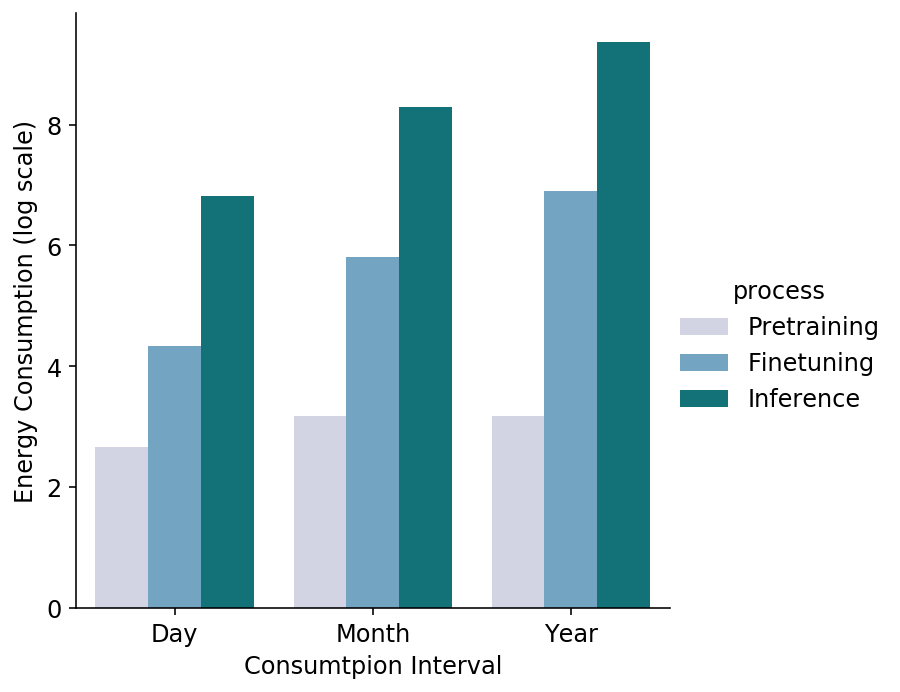

In [61]:
#plot trial
plot_df["Consumption (log scale)"] = np.log10(plot_df['consumption'])
g = sns.catplot(x="consumption_interval", y="Consumption (log scale)", hue="process", data=plot_df,
                 kind="bar", palette='PuBuGn')
g.set(ylabel="Energy Consumption (log scale)", xlabel="Consumtpion Interval")
plt.savefig('viz/overallConsumption.png',dpi=300)

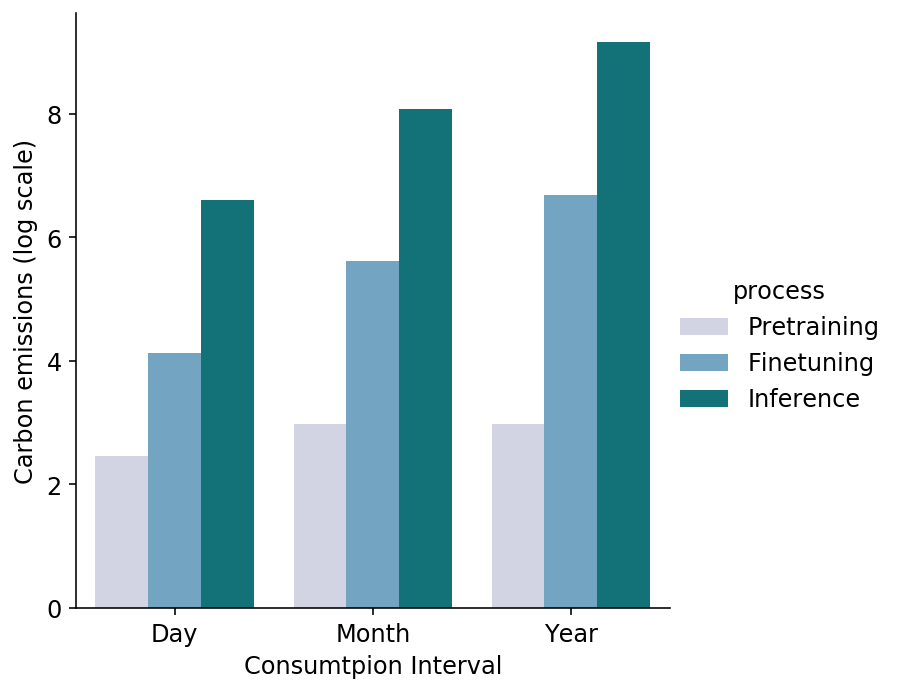

In [55]:
plot_df["CO2e (log scale)"] = np.log10(plot_df['co2'])
g = sns.catplot(x="consumption_interval", y="CO2e (log scale)", hue="process", data=plot_df,
                 kind="bar", palette='PuBuGn')
g.set(ylabel="Carbon emissions (log scale)", xlabel="Consumtpion Interval")
plt.savefig('viz/overallCO2.png',dpi=300)

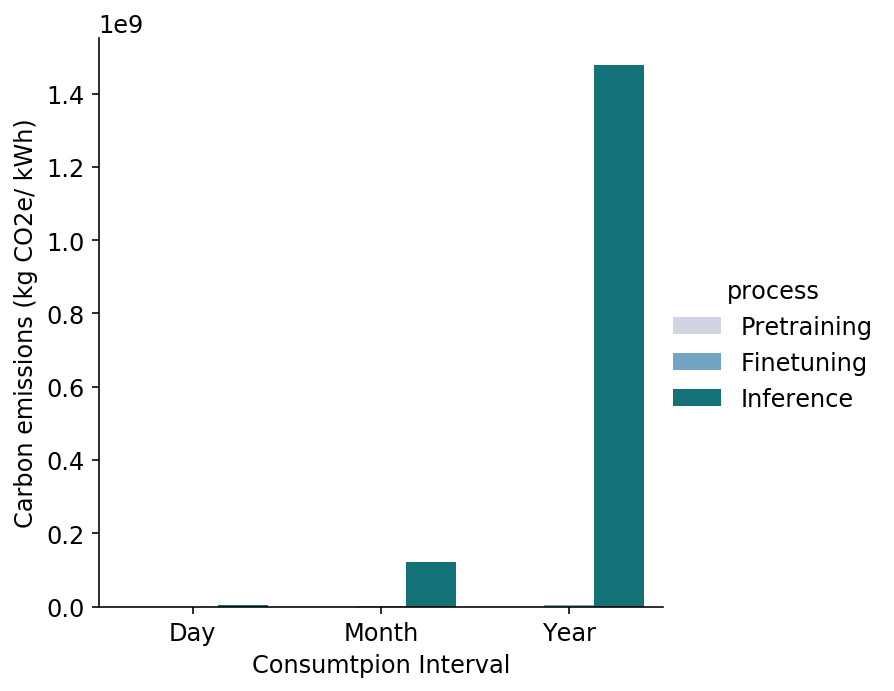

In [56]:

g = sns.catplot(x="consumption_interval", y="co2", hue="process", data=plot_df,
                 kind="bar", palette='PuBuGn')
g.set(ylabel="Carbon emissions (kg CO2e/ kWh)", xlabel="Consumtpion Interval")

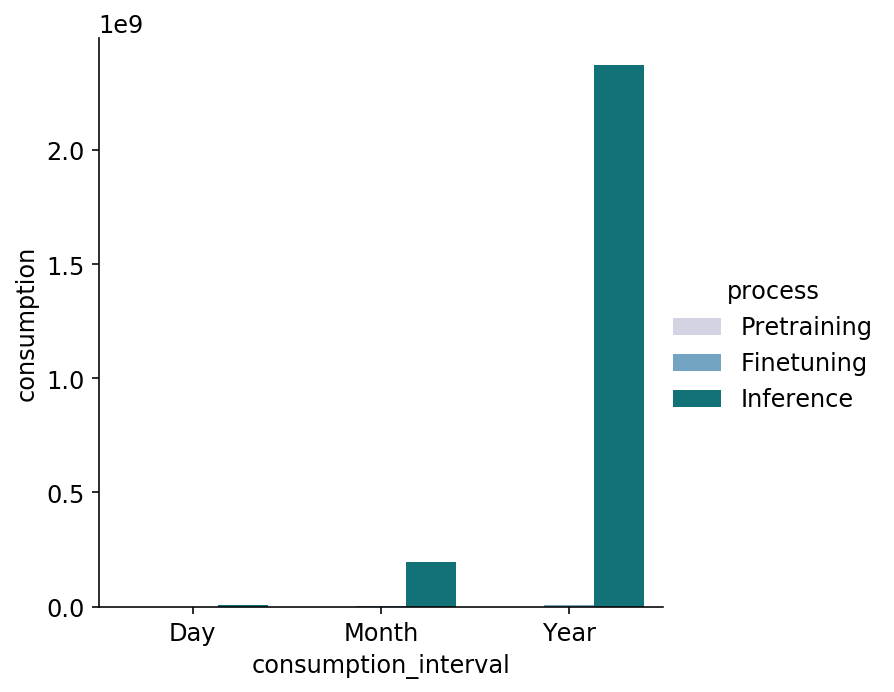

In [57]:
g = sns.catplot(x="consumption_interval", y="consumption", hue="process", data=plot_df,
                 kind="bar", palette='PuBuGn')

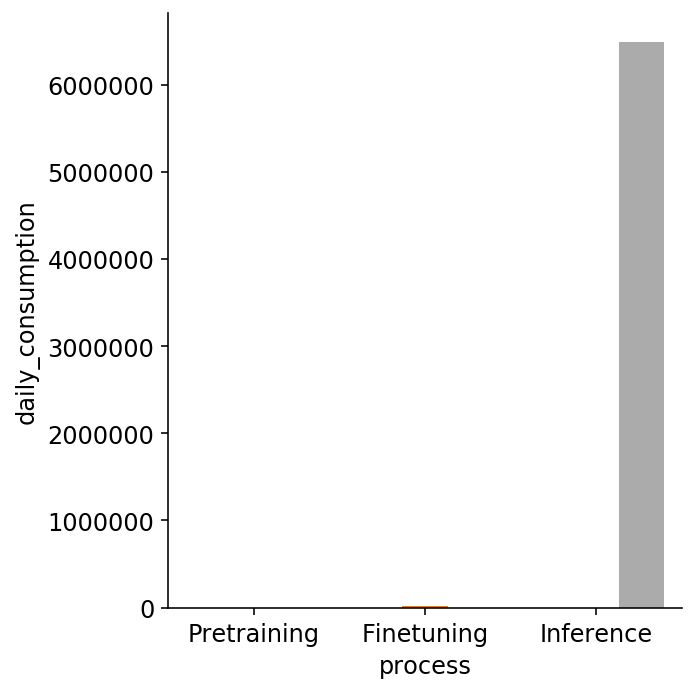

In [58]:
g = sns.catplot(x="process", y="daily_consumption", hue="process", data=mean_df,
                 kind="bar")

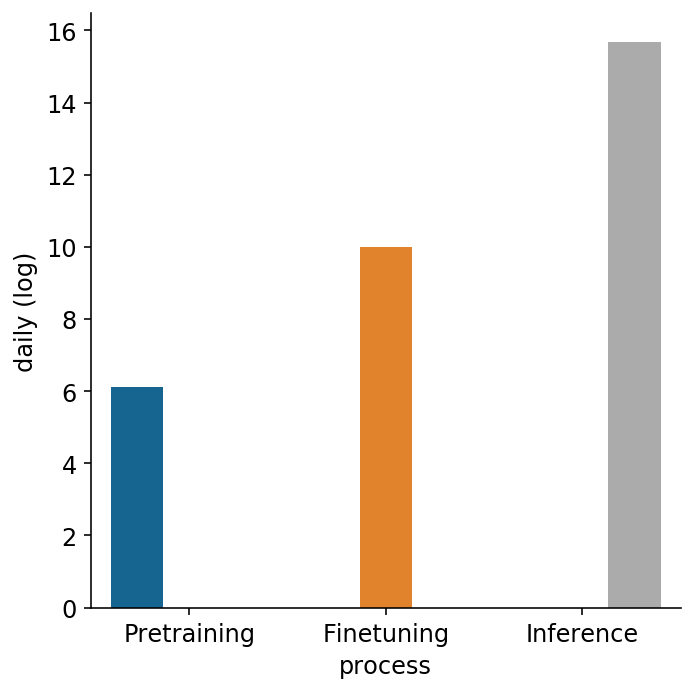

In [59]:
mean_df['daily (log)'] = np.log(mean_df['daily_consumption'])

g = sns.catplot(x="process", y="daily (log)", hue="process", data=mean_df,
                 kind="bar")

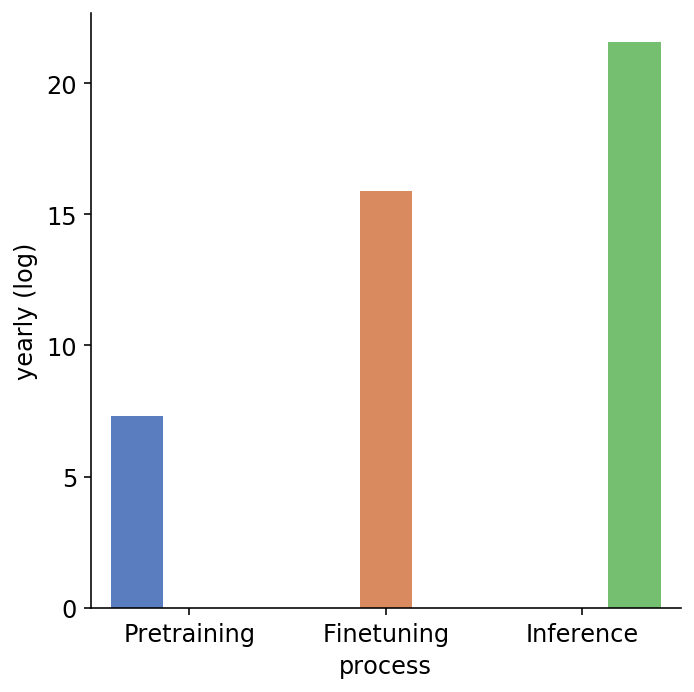

In [60]:
mean_df['yearly (log)'] = np.log(mean_df['yearly_consumption'])

g = sns.catplot(x="process", y="yearly (log)", hue="process", data=mean_df,
                 kind="bar", palette="muted")